In [1]:
import popy as popy
from popy.data_fakers.soep import soep_faker
from popy.pop_maker import PopMaker

from popy.location import WeightedLocation

import pandas as pd
import random
import matplotlib.pyplot as plt

import datetime as dt

In [2]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)

        self.infection_status = "susceptible"
        self.days_since_infection = 0
    

    def infect(self):
        if self.infection_status in ["infectious", "symptomatic"]:
            for location in self.locations:
                for agent_v in location.neighbors(self):
                    if agent_v.infection_status == "susceptible":

                        contact_weight = location.edge_weight_simultan(self, agent_v, denominator=24)
                        # -> eine Agenten-Methode schreiben, die das Gewicht zu einem anderen Agenten über alle Locations wiedergibt
                        
                        infection_probability = self.model.p.infection_weight * contact_weight
                        
                        if random.random() < infection_probability:
                            agent_v.infection_status = "exposed"
    

    def update_infection_status(self):
        if self.infection_status in ["exposed", "infectious", "symptomatic"]:
            self.days_since_infection += 1

            if 2 <= self.days_since_infection <= 5:
                self.infection_status = "infectious"
            
            elif 6 <= self.days_since_infection <= 10:
                self.infection_status = "symptomatic"
            
            elif self.days_since_infection >= 11:
                self.infection_status = "recovered"

In [3]:
class Home(WeightedLocation):
    def group(self, agent):
        return agent.hid
    
    def weight(self, agent):
        return 8


class Work(WeightedLocation):
    def setup(self):
        self.size = 10
    
    def join(self, agent):
        return agent.work_hours_day > 0

    def weight(self, agent):
        return agent.work_hours_day


class School(WeightedLocation):
    def setup(self):
        self.size = 25
    
    def join(self, agent) -> bool:
        return 6 <= agent.age <= 18
    
    def weight(self, agent):
        weight = 0
        
        # workday?
        if agent.model.date.weekday() < 5:
            # not ill?
            if agent.infection_status != "symptomatic" or agent.infection_status == "symptomatic" and random.random() < 0.5:
                # no holidays?
                if random.random() < self.model.get_timetable_entry()["school"]:
                    weight = 6

        return weight


class Friendship(WeightedLocation):
    def setup(self):
        self.size = 2
    
    def group(self, agent):
        return (abs(agent.age + random.randint(-5,5)), agent.gender)
    
    def weight(self, agent):
        return 2 if agent.model.date.weekday() >= 5 else 0

In [4]:
class Model(popy.Model):
    
    def setup(self):
        self.date = dt.date(2022, 1, 1)
        df_soep = soep_faker.soep(size=self.p.n_agents)
        self.pop_maker = PopMaker(model=self)
        self.agents = self.pop_maker.create_agents(df=df_soep, agent_class=Agent)
        self.locations = self.pop_maker.create_locations(agents=self.agents, location_classes=[Home, School, Work, Friendship])
        
        self.infection_list = []

        for agent in random.choices(self.agents, k=10):
            agent.infection_status = "exposed"
        
        self.timetable = {
            dt.date(2020, 1, 1): {
                "school": 1,
            },
            dt.date(2020, 2, 1): {
                "school": 0,
            },
            dt.date(2020, 2, 15): {
                "school": 1,
            }
        }
        

    def step(self):
        self.agents.update_infection_status()
        self.agents.infect()
        
    def update(self):
        self.record("cumulative_infections", sum([1 for agent in self.agents if agent.infection_status != "susceptible"]))
        self.date = self.date + dt.timedelta(days=1)
    
    def get_timetable_entry(self):
        for date_key in self.timetable:
            if date_key <= self.date:
                entry = self.timetable[date_key]
        return entry

Completed: 50 steps
Run time: 0:00:04.871837
Simulation finished


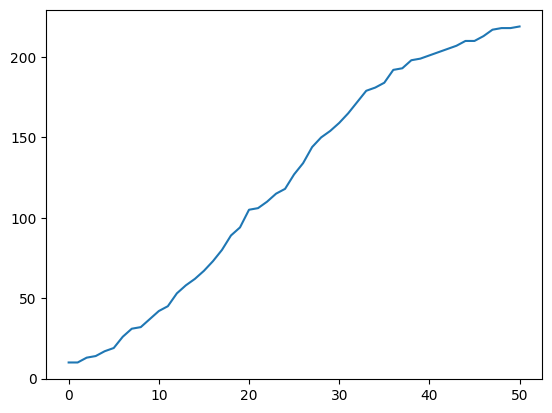

In [5]:
parameters = {
    "steps": 50,
    "n_agents": 1000,
    "infection_weight": 0.1,
}
model = Model(parameters=parameters)

results = model.run()

plt.plot(results.variables.Model.cumulative_infections)

In [6]:
model.pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                                    
                  count       mean       std   min    25%   50%   75%   max
location_class                                                             
Friendship        519.0   1.913295  0.561125   0.0   2.00   2.0   2.0   3.0
Home              325.0   3.076923  1.580238   1.0   2.00   3.0   4.0  10.0
School              4.0  22.750000  4.500000  16.0  22.75  25.0  25.0  25.0
Work               44.0   9.954545  0.301511   8.0  10.00  10.0  10.0  10.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    1000.000000
mean        2.522000
std         1.059546
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: n_affiliated_locations, dtype: float64
